In [1]:
import image_dehazer
import cv2
import copy
import numpy as np
from PIL import Image
from skimage import io, color, filters, util
import matplotlib.pyplot as plt

In [34]:
HazeImg = cv2.imread('Dataset/Scenes/scene (61).png')						# read input image
HazeCorrectedImg = image_dehazer.remove_haze(HazeImg)		# Remove Haze

cv2.imshow('input image', HazeImg);						# display the original hazy image
cv2.imshow('enhanced_image', HazeCorrectedImg);			# display the result
cv2.waitKey(0)											# hold the display window
status = cv2.imwrite('Dataset/resultImage8.png', HazeCorrectedImg)
print("Image written to file-system : ",status)

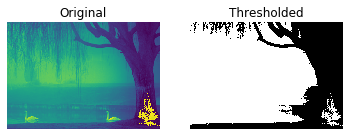

In [20]:
img1 = io.imread('depthmap.jpg')
G = util.img_as_ubyte(color.rgb2gray(img1))
T = filters.threshold_otsu(G)
S = util.img_as_float(G > T)
plt.subplot(1,2,1); plt.imshow(img1)
plt.title('Original'); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(S, cmap='gray')
plt.title("Thresholded"); plt.axis("off")
plt.show()
# io.imsave("result4.jpg", S)



In [19]:
run_file('Dataset/Scenes/scene (2).png')

Evaluating dark channel
Evaluating dark channel


In [16]:
def gen_dark_channel(img, window):
    ''' Implementation of the method used in the paper'''
    '''get image size and num_channels'''
    R,C,D = img.shape
    '''pad image at the ends with a square of side window/2 to get minimum comparision at the ends'''
    pad_img = np.pad(img, ((window/2,window/2), (window/2, window/2), (0,0)), 'edge')
    print ("Generating dark image...")
    sh = (R,C)
    channel_dark = np.zeros(sh)
    count = 0
    for r,c in np.ndindex(sh):
        channel_dark[r,c] = np.min(pad_img[r:r + window, c:c + window, :])
    return channel_dark


def boxfilter(img, r):
    ''' To be used for the guided filter '''
    (rows, cols) = img.shape
    imDst = np.zeros_like(img)

    imCum = np.cumsum(img, 0)
    imDst[0 : r+1, :] = imCum[r : 2*r+1, :]
    imDst[r+1 : rows-r, :] = imCum[2*r+1 : rows, :] - imCum[0 : rows-2*r-1, :]
    imDst[rows-r: rows, :] = np.tile(imCum[rows-1, :], [r, 1]) - imCum[rows-2*r-1 : rows-r-1, :]

    imCum = np.cumsum(imDst, 1)
    imDst[:, 0 : r+1] = imCum[:, r : 2*r+1]
    imDst[:, r+1 : cols-r] = imCum[:, 2*r+1 : cols] - imCum[:, 0 : cols-2*r-1]
    imDst[:, cols-r: cols] = np.tile(imCum[:, cols-1], [r, 1]).T - imCum[:, cols-2*r-1 : cols-r-1]

    return imDst


def guidedfilter(I, p, r, eps):
    ''' Filters p, guided by the image I. Uses r for the box filter radius'''
    (rows, cols) = I.shape
    N = boxfilter(np.ones([rows, cols]), r)

    meanI = boxfilter(I, r) / N
    meanP = boxfilter(p, r) / N
    meanIp = boxfilter(I * p, r) / N
    covIp = meanIp - meanI * meanP

    meanII = boxfilter(I * I, r) / N
    varI = meanII - meanI * meanI

    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = boxfilter(a, r) / N
    meanB = boxfilter(b, r) / N

    q = meanA * I + meanB
    return q


def faster_dark_channel(img, kernel):
    '''Method to evaluate the dark channel faster'''
    print ("Evaluating dark channel")
    temp = np.amin(img, axis = 2)
    return cv2.erode(temp, kernel)

def atmosphere(img, channel_dark, top_percent):
    R, C, D = img.shape
    # flatten dark to get top thres percentage of bright points. Paper uses thres_percent = 0.1
    flat_dark = channel_dark.ravel()
    req = int((R * C * top_percent)/ 100)
    ''' find indices of top req intensites in dark channed'''
    indices = np.argpartition(flat_dark, -req)[-req:]

    '''flatten image and take max among these pixels '''
    flat_img = img.reshape(R * C,3)
    return np.max(flat_img.take(indices, axis = 0), axis = 0)

def eval_transmission(dark_div, param):
    '''returns the estimated transmission'''
    transmission = 1 - param * dark_div
    return transmission

def bug_guided_filter(img, p, r, eps):
    D = img.shape[2]
    temp = np.empty(img.shape)
    for i in range(D):
        temp[:,:,i] = p
    I_n = img
    p_n = temp
    r_n = r
    k_size = (r_n, r_n)

    mean_I = cv2.blur(I_n, ksize = k_size)
    mean_p = cv2.blur(p_n, ksize = k_size)
    corr_I = cv2.blur(np.multiply(I_n, I_n), ksize = k_size)
    corr_I_p = cv2.blur(np.multiply(I_n, p_n), ksize = k_size)

    var_I = corr_I - np.multiply(mean_I, mean_I)
    cov_I_p = corr_I_p - np.multiply(mean_I, mean_p)

    ep = np.full((1,1,3), eps)

    a = np.divide(cov_I_p, var_I + ep)
    b = mean_p - np.multiply(a, mean_I)

    mean_a = cv2.blur(a, ksize = k_size)
    mean_b = cv2.blur(b, ksize = k_size)

    q = np.multiply(mean_a, img) + mean_b
    return q


def depth_map(trans, beta):
    rval = -np.log(trans)/beta
    return rval / np.max(rval)

def radiant_image(image, atmosphere, t, thres):
    R,C,D = image.shape
    temp = np.empty(image.shape)
    t[t < thres] = thres
    for i in range(D):
        temp[:,:,i] = t
    b = (image - atmosphere)/temp + atmosphere
    b[b>255] = 255
    return b


def perform(orig_img, window = 50, top_percent = 0.1, thres_haze = 0.1, omega = 0.95, beta = 1.0, radius = 100, eps = 0.001):
    img_gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    img = np.asarray(orig_img, dtype = np.float64)
    img_norm = (img_gray - img_gray.mean())/(img_gray.max() - img_gray.min())
    kernel = np.ones((window, window), np.float64)
    dark = faster_dark_channel(img,kernel)
    A = atmosphere(img, dark, top_percent)
    B = img / A

    dark_div = faster_dark_channel(B, kernel)
    t_estimate = eval_transmission(dark_div, omega)
    R,C,_ = img.shape
    t_refined = guidedfilter(img_norm, t_estimate, radius, eps)
    # t_refined = fast_guided_filter(img, t_estimate, radius, eps)
    unhazed = radiant_image(img, A, t_refined, thres_haze)
    depthmap = depth_map(t_refined, beta)
    return [np.array(x, dtype = np.uint8) for x in [t_estimate * 255, t_refined * 255, unhazed, dark, depthmap * 255] ]


def run_file(fileName):
    frame = cv2.imread(fileName)
    [trans, trans_refined, radiance, dark, depthmap] = perform(frame)
    # cv2.imshow('original.jpg', frame)
    cv2.imshow('unhazed', radiance)
    cv2.imwrite('unhazed.jpg', radiance)
    cv2.imwrite('transmission.jpg', trans_refined)
    cv2.imwrite('dark-channel.jpg', dark)
    cv2.imwrite('depthmap.jpg', depthmap)
    cv2.waitKey(0)
